Files already downloaded and verified
Files already downloaded and verified
Training Teacher Model...


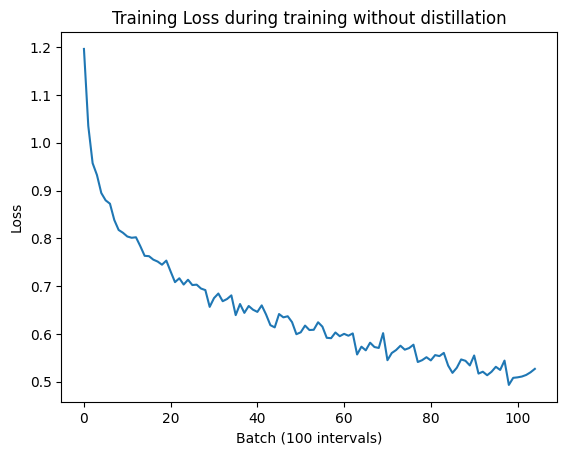

Teacher model testing:
Accuracy: 64.88%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.view(-1, 16 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

def train_teacher(model, optimizer, criterion, epochs=15, alpha=0.6):
    model.train()
    training_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss_soft = F.kl_div(F.log_softmax(outputs, dim=1),
                                     F.softmax(outputs.detach(), dim=1),
                                     reduction='batchmean')

            # Hard loss
            loss_hard = criterion(outputs, targets)

            # Kombinovaná ztráta
            loss = alpha * loss_hard + (1 - alpha) * loss_soft
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                #print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                training_losses.append(running_loss / 100)
                running_loss = 0.0
    # Plotting training loss over time
    plt.plot(training_losses)
    plt.xlabel('Batch (100 intervals)')
    plt.ylabel('Loss')
    plt.title('Training Loss during training without distillation')
    plt.show()
    return training_losses;

def test_model(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
    print(f'Accuracy: {100. * correct / len(test_loader.dataset)}%')

teacher_model = TeacherModel().to(device)
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Training Teacher Model...")
train_teacher(teacher_model, teacher_optimizer, criterion)
print("Teacher model testing:")
test_model(teacher_model)

Training with Distillation with switch_epoch = 0
Accuracy: 76.7%
Training with Distillation with switch_epoch = 1
Accuracy: 78.28%
Training with Distillation with switch_epoch = 2
Accuracy: 76.65%
Training with Distillation with switch_epoch = 3
Accuracy: 76.7%
Training with Distillation with switch_epoch = 4
Accuracy: 76.84%
Training with Distillation with switch_epoch = 5
Accuracy: 75.5%
Training with Distillation with switch_epoch = 6
Accuracy: 76.64%
Training with Distillation with switch_epoch = 7
Accuracy: 74.95%
Training with Distillation with switch_epoch = 8
Accuracy: 76.62%
Training with Distillation with switch_epoch = 9
Accuracy: 76.35%
Training with Distillation with switch_epoch = 10
Accuracy: 77.5%
Training with Distillation with switch_epoch = 11
Accuracy: 74.53%
Training with Distillation with switch_epoch = 12
Accuracy: 76.15%
Training with Distillation with switch_epoch = 13
Accuracy: 77.07%
Training with Distillation with switch_epoch = 14
Accuracy: 76.05%
Training 

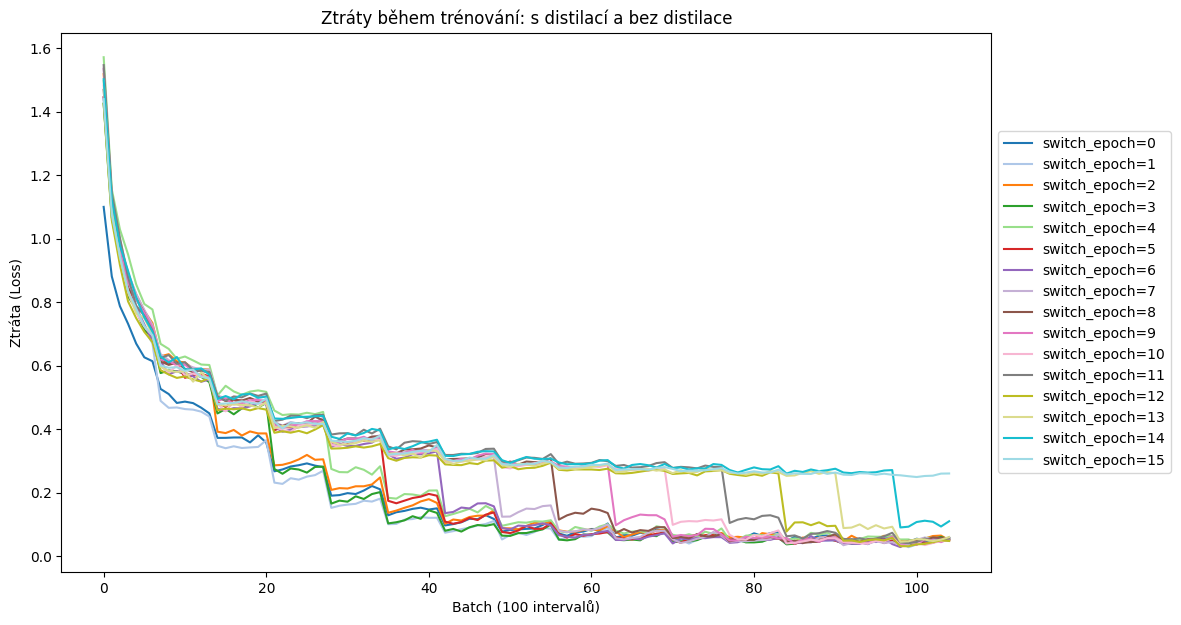

In [2]:
class StudentModel(nn.Module):
    def __init__(self, input_size=32):  # input_size=32 pro CIFAR-10
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        fc_input_dim = (input_size // 4) * (input_size // 4) * 256  # Dvě pooling vrstvy -> rozměr / 4

        self.fc1 = nn.Linear(fc_input_dim, 512)
        self.fc3 = nn.Linear(512, 10)  # 10 tříd pro CIFAR-10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc3(x)

def train_student(student_model, teacher_model, optimizer, switch_epoch, epochs, alpha=0.6):
    student_model.train()
    teacher_model.eval()
    training_losses = []

    for epoch in range(epochs):
        running_loss = 0.0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Student outputs
            student_outputs = student_model(inputs)

            if epoch < switch_epoch:
                # Pouze v prvních epochách používáme teacher outputs
                with torch.no_grad():
                    teacher_outputs = teacher_model(inputs)

                loss_soft = F.kl_div(F.log_softmax(student_outputs, dim=1),
                                     F.softmax(teacher_outputs, dim=1),
                                     reduction='batchmean')
            else:
                # Po určitém počtu epoch už KL divergence porovnává pouze studenta se sebou samým
                loss_soft = F.kl_div(F.log_softmax(student_outputs, dim=1),
                                     F.softmax(student_outputs.detach(), dim=1),
                                     reduction='batchmean')

            # Hard loss
            loss_hard = criterion(student_outputs, targets)

            # Kombinovaná ztráta
            loss = alpha * loss_hard + (1 - alpha) * loss_soft

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:  # Print every 100 mini-batches
                #print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                training_losses.append(running_loss / 100)
                running_loss = 0.0

    #plt.plot(training_losses)
    #plt.xlabel('Batch (100 intervals)')
    #plt.ylabel('Loss')
    #plt.title('Training Loss during Distillation')
    #plt.show()
    return training_losses;


results = {}
epochs = 16
for switch_epoch in range(epochs):
    print(f"Training with Distillation with switch_epoch = {switch_epoch}")

    student_model = StudentModel().to(device)
    student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)

    training_losses = train_student(student_model, teacher_model, student_optimizer, switch_epoch, 15)
    results[switch_epoch] = training_losses
    test_model(student_model)

plt.figure(figsize=(12, 7))
colors = plt.cm.tab20(np.linspace(0, 1, epochs))
for idx, (switch_epoch, losses) in enumerate(results.items()):
    plt.plot(losses, label=f'switch_epoch={switch_epoch}', color=colors[idx])

plt.xlabel('Batch (100 intervalů)')
plt.ylabel('Ztráta (Loss)')
plt.title('Ztráty během trénování: s distilací a bez distilace')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


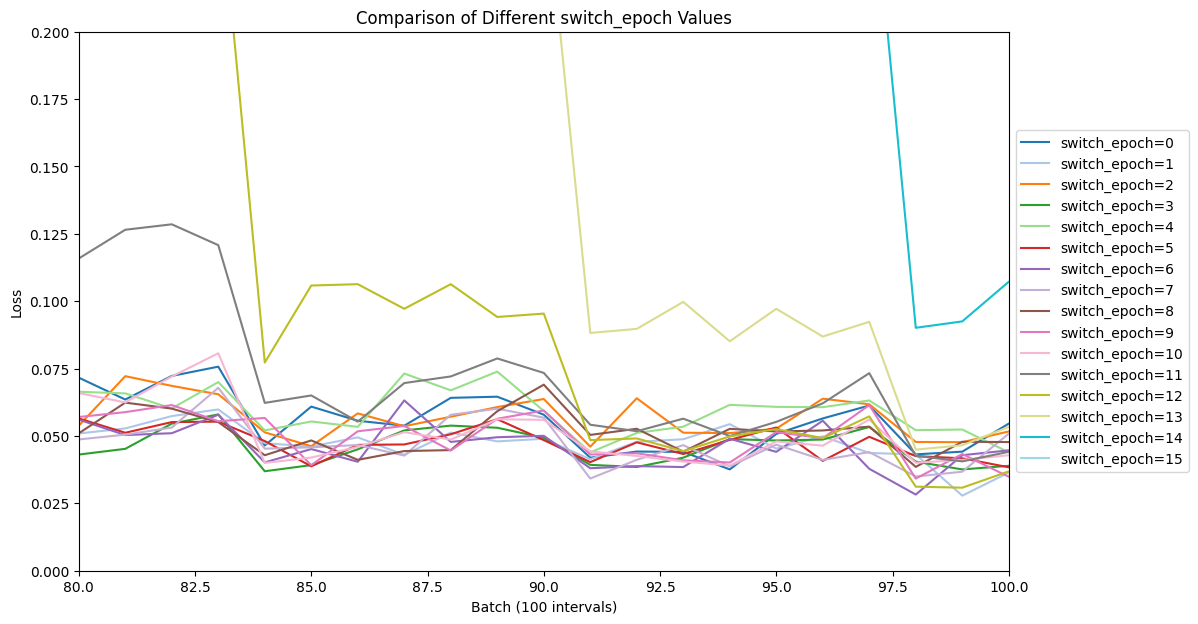

In [3]:

plt.figure(figsize=(12, 7))
for idx, (switch_epoch, losses) in enumerate(results.items()):
    plt.plot(losses, label=f'switch_epoch={switch_epoch}', color=colors[idx])
plt.xlabel('Batch (100 intervals)')
plt.ylabel('Loss')
plt.title('Comparison of Different switch_epoch Values')

plt.xlim(80, 100)
plt.ylim(0, 0.2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

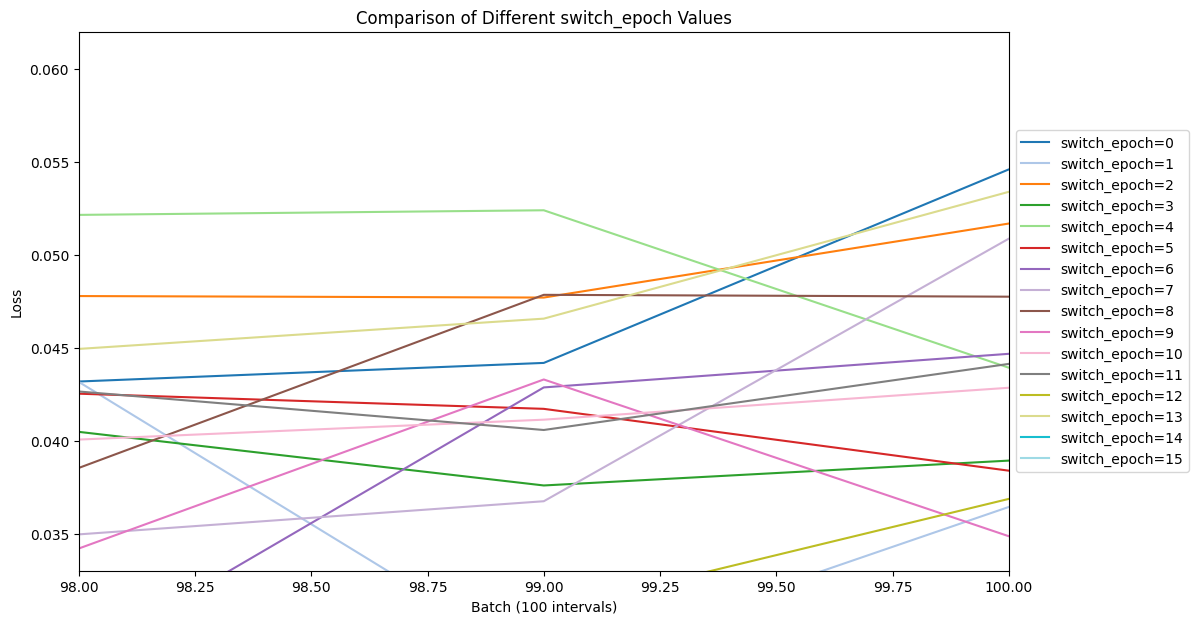

In [4]:
plt.figure(figsize=(12, 7))

for idx, (switch_epoch, losses) in enumerate(results.items()):
    plt.plot(losses, label=f'switch_epoch={switch_epoch}', color=colors[idx])
plt.xlabel('Batch (100 intervals)')
plt.ylabel('Loss')
plt.title('Comparison of Different switch_epoch Values')

plt.xlim(98, 100)
plt.ylim(0.033, 0.062)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()